Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the SMS Spam Collection dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
tfds.disable_progress_bar()

Get data files

In [3]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-02-11 15:41:52--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.1s    

2022-02-11 15:41:53 (2.38 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2022-02-11 15:41:53--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.1’

valid-data.tsv.1    100%[====

Prepare data
Train data frame

In [6]:
train_df = pd.read_csv(train_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


Test data frame

In [17]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
test_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Prepare labels for training

In [18]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [19]:
train_df.head()

,type,msg
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


In [20]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [21]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

This step is important. It's not only about batching the data sets, but also reshape it to make it works when fitting the model. Otherwise, we will get incompatible layers errors: expecting ndim=3, got ndim=2.

In [22]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create a TextVectorization layer for our model

In [23]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

Let's show the vocabulary that our vectorizer has learned.

In [24]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

Create the model

In [25]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

Train the model against our data sets.

In [35]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
131/131 [==============================] - 442s 3s/step - loss: 0.0472 - accuracy: 0.9890 - val_loss: 0.0578 - val_accuracy: 0.9854
Epoch 2/10
131/131 [==============================] - 423s 3s/step - loss: 0.0370 - accuracy: 0.9904 - val_loss: 0.0575 - val_accuracy: 0.9854
Epoch 3/10
131/131 [==============================] - 430s 3s/step - loss: 0.0313 - accuracy: 0.9921 - val_loss: 0.0581 - val_accuracy: 0.9854
Epoch 4/10
131/131 [==============================] - 428s 3s/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 0.0589 - val_accuracy: 0.9844
Epoch 5/10
131/131 [==============================] - 430s 3s/step - loss: 0.0188 - accuracy: 0.9962 - val_loss: 0.0637 - val_accuracy: 0.9844
Epoch 6/10
131/131 [==============================] - 431s 3s/step - loss: 0.0163 - accuracy: 0.9966 - val_loss: 0.0675 - val_accuracy: 0.9844
Epoch 7/10
131/131 [==============================] - 428s 3s/step - loss: 0.0133 - accuracy: 0.9976 - val_loss: 0.0731 - val_accuracy: 0.9844

In [36]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 26s 588ms/step - loss: 0.0719 - accuracy: 0.9871


In [37]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.07188740372657776
Test Accuracy: 0.9870689511299133


Plot the accuracy and loss metrics
Create a helper function to plot

In [38]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

Plot the graphs

(0.0, 0.0789617020636797)

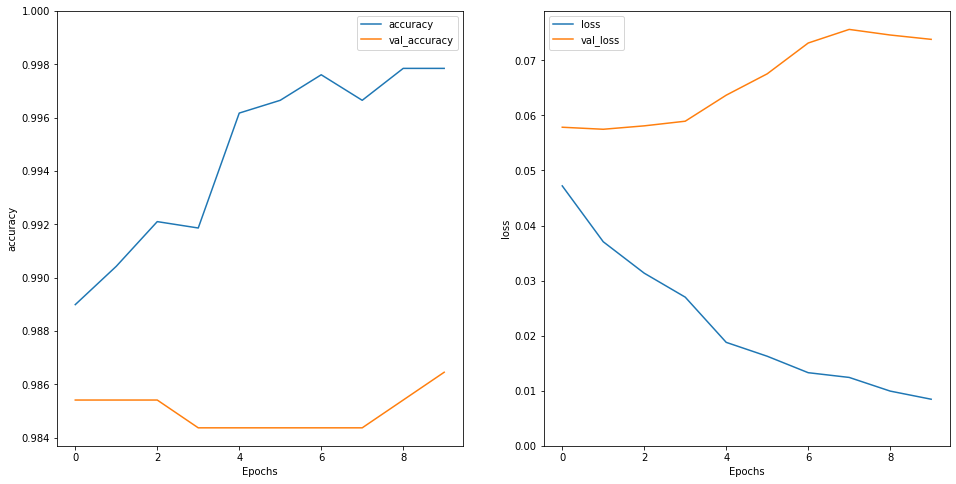

In [39]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [40]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.04719363898038864, 0.037049535661935806, 0.03134259954094887, 0.026991477236151695, 0.018782364204525948, 0.016261566430330276, 0.013274773955345154, 0.012413387186825275, 0.00993321929126978, 0.008456356823444366]
[0.057842426002025604, 0.057473696768283844, 0.05809362977743149, 0.058935947716236115, 0.06366279721260071, 0.06754127889871597, 0.07313406467437744, 0.07560430467128754, 0.0745871290564537, 0.07379928231239319]
[0.9889925718307495, 0.9904283285140991, 0.9921033978462219, 0.9918640851974487, 0.9961713552474976, 0.9966499209403992, 0.9976071119308472, 0.9966499209403992, 0.9978463649749756, 0.9978463649749756]
[0.9854166507720947, 0.9854166507720947, 0.9854166507720947, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.9854166507720947, 0.9864583611488342]


In [41]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[[-7.465166]]
[-7.465166, 'ham']


In [42]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

[[-7.465166]]
[[0.77896786]]
[[-15.786137]]
[[6.5271835]]
[[4.5149984]]
[[-13.901805]]
[[-15.857913]]
You passed the challenge. Great job!
